In [1]:
import os
import shutil
import random
import time
import math
import cv2
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from utils import show_image, parseBBOXFile, getTagValue

In [2]:
%matplotlib inline

In [3]:
def getImagesOfInterest(path):
    """Return a list of images + their respective xml bbox+labels file."""
    files = []
    for filename in os.listdir(path):
        f = '{}/{}.xml'.format(path, filename[:-4]) # Target file for obj. and bboxes.
        if (not filename.endswith(".jpg")) or (not os.path.isfile(f)):
            continue
        files.append(filename[:-4].lower())
    return files

Move raw images plus their respective xml/json bounding box + object files to train / test / valid

In [12]:
WEIGHT = {
    'car': 0,
    'truck': 1,
    'bus': 2,
    'person': 3,
    'bike': 4,
}

def getWeightForLabel(lbl):
    return (WEIGHT[lbl] if (lbl in WEIGHT) else -1)

WEIGHT

{'car': 0, 'truck': 1, 'bus': 2, 'person': 3, 'bike': 4}

In [13]:
def createTrainTestSplit(files, perc):
    if (len(files) <= 1): # Special case.
        print(len(files), '--->', len(files), 0)
        return files, []
    
    random.shuffle(files)
    items = int(len(files)*perc)
    train = files[:items]
    test = files[items:]
    print(len(files), '--->', len(train), len(test))
    return train, test
    
def createGroups(path):
    grps = defaultdict(list)
    for f in getImagesOfInterest(path):
        labels = list(set([getTagValue(obj, 'name') for obj in parseBBOXFile('{}/{}.xml'.format(path, f))]))
        if len(labels) == 0:
            continue
        labels.sort(key=lambda x: getWeightForLabel(x), reverse=True)
        grps[labels[0]].append(f) # Add file to the highest priority label.
    return grps

def createDataSplit(out, path, perc=0.9):
    train, test = [], [] # Output train and test files!
    g = createGroups(path) # Split data into car, truck, bus, ... Guarantee that we train and test on all classes.
    print('Group Distribution:', ', '.join(['{} {}'.format(k, len(v)) for k, v in g.items()]))
    
    for files in g.values(): # Now split each group into train and test.
        train_split, test_split = createTrainTestSplit(files, perc)
        train += train_split
        test += test_split
    
    print("Finished train-test split, using", perc, '% train and', 1-perc, 'test.')
    folder = path.lower().replace('\\', '/').split('/')[-1]
    train.sort()
    test.sort()
    
    with open('../images/train/{}.txt'.format(out), 'w') as target:
        for f in train:
            target.write('{}/{}\n'.format(folder, f))
            
    with open('../images/test/{}.txt'.format(out), 'w') as target:
        for f in test:
            target.write('{}/{}\n'.format(folder, f))
            
    print("Wrote the train-test split files into train and test respectively.")    

In [114]:
#createDataSplit('raw', '../images/raw')

Group Distribution: car 490, truck 209, bus 72, bike 1
490 ---> 441 49
209 ---> 188 21
72 ---> 64 8
1 ---> 1 0
Finished train-test split, using 0.9 % train and 0.09999999999999998 test.
Wrote the train-test split files into train and test respectively.


In [14]:
createDataSplit('dark', '../images/dark')

Group Distribution: person 954, bus 267, bike 535, car 520
954 ---> 858 96
267 ---> 240 27
535 ---> 481 54
520 ---> 468 52
Finished train-test split, using 0.9 % train and 0.09999999999999998 test.
Wrote the train-test split files into train and test respectively.


Crop and save regions from images, based on respective XML file.

In [115]:
def createImagesFromBBOX(path='../images/raw'):
    vehicles = {}
    for f in getImagesOfInterest(path):
        jpg, xml = '{}/{}.jpg'.format(path, f), '{}/{}.xml'.format(path, f)
        img = cv2.imread(jpg, cv2.IMREAD_COLOR)
        for obj in parseBBOXFile(xml):
            label = getTagValue(obj, 'name')
            vehicles[label] = vehicles.get(label, 0) + 1
            xmin = int(getTagValue(obj, 'xmin'))
            ymin = int(getTagValue(obj, 'ymin'))
            xmax = int(getTagValue(obj, 'xmax'))
            ymax = int(getTagValue(obj, 'ymax'))
            print(label, xmin, ymin, xmax, ymax)
            img_region = img[ymin:ymax, xmin:xmax].copy()
            show_image(img_region, size=(2,1))
            cv2.imwrite('../images/raw_classify/{}_{}.jpg'.format(label, vehicles[label]), img_region)
        break # Do this if we need to train a classifier with no region proposal stuff.

In [116]:
#createImagesFromBBOX()

In [8]:
def getNumObjects(path='../images/raw'):
    num = 0
    for f in getImagesOfInterest(path):
        num += len(parseBBOXFile('{}/{}.xml'.format(path, f)))
    return num

def getNumObjectsOfType(path='../images/raw'):
    types = defaultdict(int)
    for f in getImagesOfInterest(path):
        for obj in parseBBOXFile('{}/{}.xml'.format(path, f)):
            label = getTagValue(obj, 'name')
            types[label] = (types[label] + 1)
    return types

In [118]:
getNumObjects()

5215

In [9]:
getNumObjects('../images/dark')

8119

In [119]:
def scramble(path='../images/raw'):
    """Move a selected grp of images, shuffle and copy X images over to temp."""
    files = []
    for filename in os.listdir(path):
        f = '{}/{}.xml'.format(path, filename[:-4]) # Target file for obj. and bboxes.
        if (not filename.endswith(".jpg")) or (os.path.isfile(f)):
            continue
        if not (('_18-01' in filename) or ('_19-01' in filename)):
            continue
        files.append(filename[:-4])
        
    grps = {}
    for f in files:
        idx = f.find('_18-01')
        if idx == -1:
            idx = f.find('_19-01')
        if not (f[:idx] in grps):        
            grps[f[:idx]] = []
        grps[f[:idx]].append(f)
    
    files = []
    for k, v in grps.items():
        random.shuffle(v)
        random.shuffle(v)
        files += v[:10]
        
    print('Copying to temp:\n', files)
    for f in files:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/temp/{}.jpg'.format(f))

In [120]:
#scramble()

In [10]:
def hist(d):
    """Plot Histogram of Gradient for a given bin vector."""
    X = []
    for i, v in enumerate(d.values()):
        X.extend((np.zeros(int(round(v)), dtype=np.uint64)+i).tolist())
    fig, ax = plt.subplots(1, figsize=(26,14), tight_layout=True)
    ax.hist(X, bins=np.arange(len(d)+1)-0.5, rwidth=0.35)
    ax.set_title('Vehicle Distribution', fontsize=24)
    ax.set_xlabel('Vehicle', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    ax.set_xticklabels(list(d.keys()))
    plt.xticks(np.arange(len(d)), fontsize=20)
    plt.yticks(fontsize=20)
    #plt.savefig('./fig/plot_bins.png', transparent=False, bbox_inches='tight')
    plt.show()

<ipython-input-121-188fd65fd25c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(d.keys()))


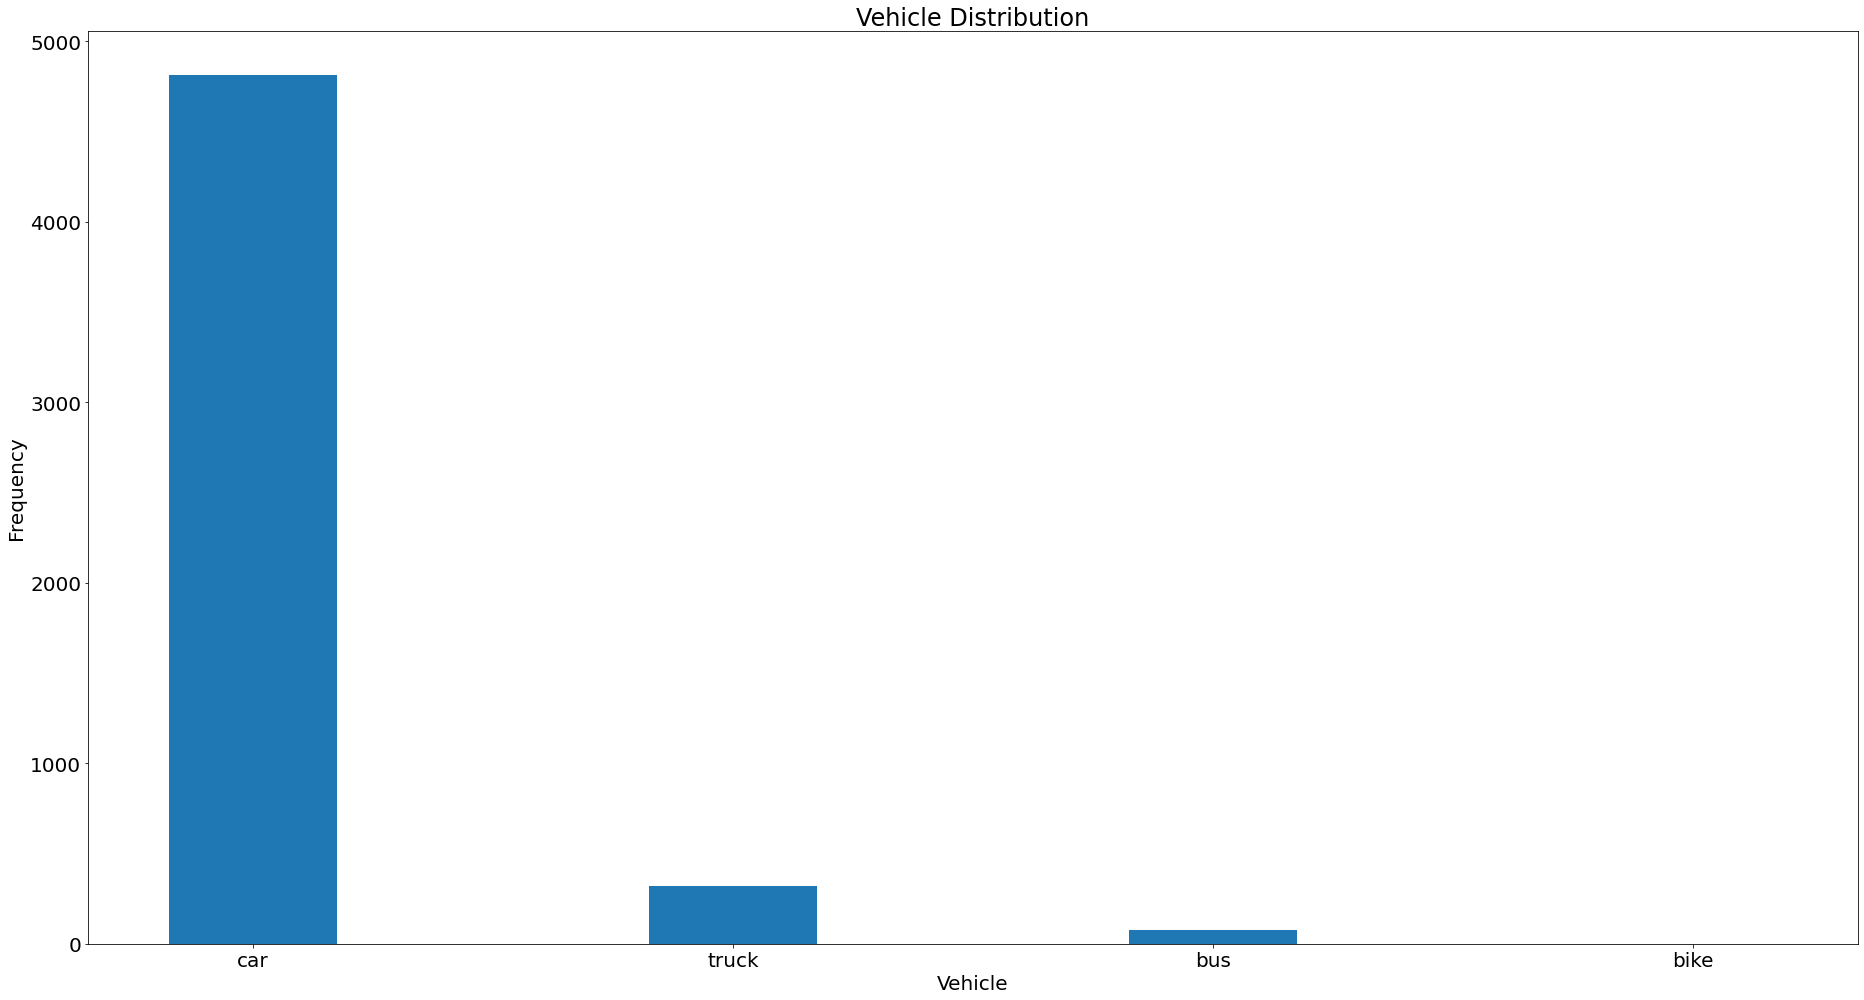

In [122]:
veh_typ = getNumObjectsOfType()
hist(veh_typ)

In [123]:
veh_typ

defaultdict(int, {'car': 4815, 'truck': 322, 'bus': 77, 'bike': 1})

<ipython-input-10-188fd65fd25c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(d.keys()))


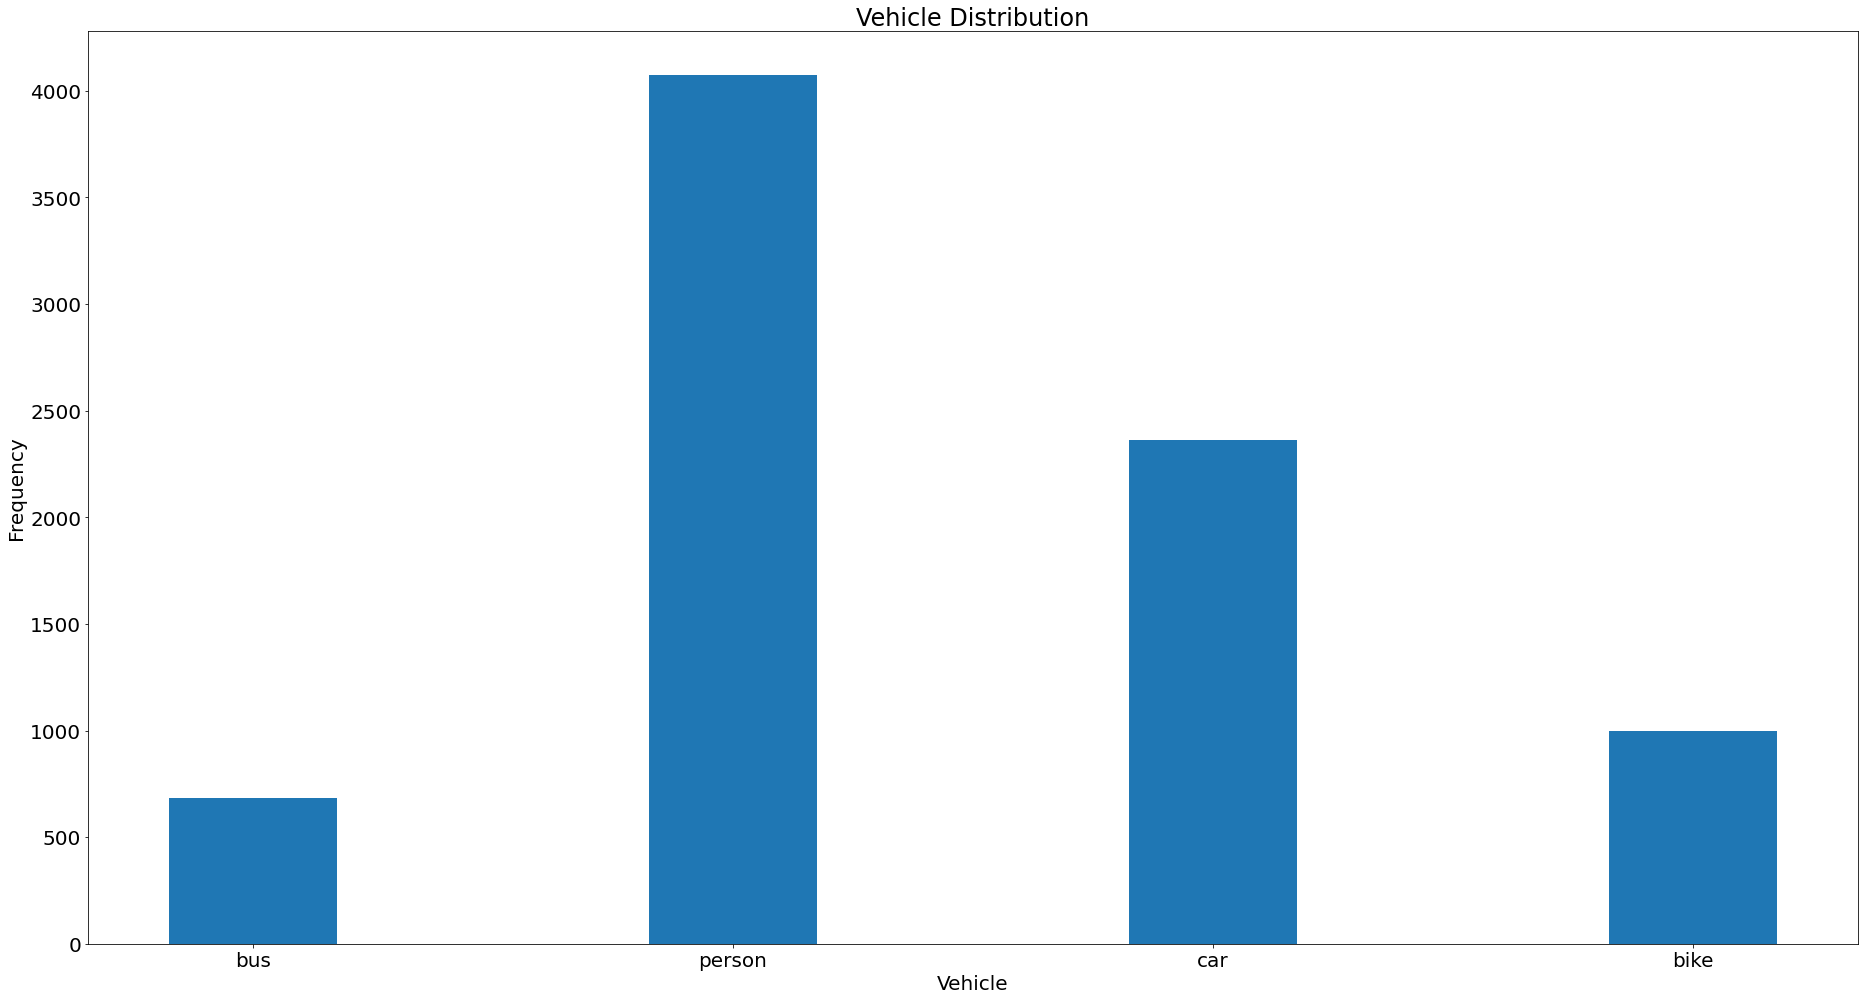

In [11]:
hist(getNumObjectsOfType('../images/dark'))